# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                 
Sample_097  P68104;Q5VTE0                     14.971
Sample_088  O94769                            17.484
Sample_192  F6SYP7;P98153;P98153-2;P98153-3   14.874
Sample_173  C9J8T4;C9JYN7;O43567              16.570
Sample_050  P01258;P01258-2;P06881            15.267
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups
Sample_098  Q96IU4           12.877
Sample_196  P13489           11.682
Sample_065  Q6UWP8           10.889
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.269
            A0A075B6Q5                 13.253
            A0A075B6R2                 12.235
            A0A075B6S5                 12.980
            A0A087WSY4                 12.789
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.316
            Q9UI40;Q9UI40-2            11.662
            Q9UIW2                     13.186
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.300
            Q9UP79                     13.013
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,12.256,15.050,16.842,19.863,14.057,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,14.785,19.067,...,15.528,15.576,13.052,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,13.478,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.170,17.705,17.039,14.252,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.939,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,13.041,15.345,17.084,18.708,14.249,19.433,10.237,9.344
Sample_207,15.739,16.877,15.469,16.898,12.418,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,13.269,...,16.012,15.178,13.646,15.050,16.842,19.863,12.085,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.470,19.067,16.188,...,15.528,15.576,12.787,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.595,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.828,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.205,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.421,15.345,17.084,18.708,14.249,19.433,12.377,13.989
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 71.68it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.46it/s]

100%|██████████| 2/2 [00:00<00:00,  6.40it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.68it/s]

100%|██████████| 3/3 [00:00<00:00,  4.25it/s]

100%|██████████| 3/3 [00:00<00:00,  4.47it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.55it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.60it/s]

100%|██████████| 4/4 [00:01<00:00,  3.00it/s]

100%|██████████| 4/4 [00:01<00:00,  3.50it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.73it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.30it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.64it/s]

100%|██████████| 5/5 [00:01<00:00,  3.53it/s]

100%|██████████| 5/5 [00:01<00:00,  3.81it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.53it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.67it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.85it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.59it/s]

100%|██████████| 6/6 [00:01<00:00,  3.44it/s]

100%|██████████| 6/6 [00:01<00:00,  3.82it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.66it/s]

 43%|████▎     | 3/7 [00:00<00:01,  4.00it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.54it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.93it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.68it/s]

100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

100%|██████████| 7/7 [00:02<00:00,  3.04it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.67it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.48it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.06it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.13it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.15it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  3.16it/s]

100%|██████████| 8/8 [00:02<00:00,  3.20it/s]

100%|██████████| 8/8 [00:02<00:00,  3.27it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.18it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.58it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.98it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.91it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.70it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.82it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.75it/s]

100%|██████████| 9/9 [00:02<00:00,  3.70it/s]

100%|██████████| 9/9 [00:02<00:00,  3.93it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.83it/s]

 30%|███       | 3/10 [00:00<00:01,  3.90it/s]

 40%|████      | 4/10 [00:01<00:01,  3.60it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.11it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.99it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.11it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.89it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.81it/s]

100%|██████████| 10/10 [00:03<00:00,  2.98it/s]

100%|██████████| 10/10 [00:03<00:00,  3.16it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.56it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.04it/s]

 36%|███▋      | 4/11 [00:01<00:01,  3.65it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.32it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.19it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.98it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.56it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.54it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.32it/s]

100%|██████████| 11/11 [00:03<00:00,  2.26it/s]

100%|██████████| 11/11 [00:04<00:00,  2.75it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.25it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.30it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.64it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.36it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.38it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.54it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.80it/s]

 75%|███████▌  | 9/12 [00:03<00:00,  3.05it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  3.14it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.24it/s]

100%|██████████| 12/12 [00:03<00:00,  3.35it/s]

100%|██████████| 12/12 [00:03<00:00,  3.01it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.80it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.90it/s]

 31%|███       | 4/13 [00:00<00:02,  4.06it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.75it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.61it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.48it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.95it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.52it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.32it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.29it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.43it/s]

100%|██████████| 13/13 [00:04<00:00,  2.54it/s]

100%|██████████| 13/13 [00:04<00:00,  2.92it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.49it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.64it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.41it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.25it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.14it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.38it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.27it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.16it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.15it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.10it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.15it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.17it/s]

100%|██████████| 14/14 [00:04<00:00,  3.23it/s]

100%|██████████| 14/14 [00:04<00:00,  3.29it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.68it/s]

 20%|██        | 3/15 [00:00<00:02,  4.50it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.90it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.55it/s]

 40%|████      | 6/15 [00:01<00:02,  3.52it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.41it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.39it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.39it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.37it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.74it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.58it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.41it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.44it/s]

100%|██████████| 15/15 [00:04<00:00,  2.60it/s]

100%|██████████| 15/15 [00:04<00:00,  3.05it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.000      0.045 0.005          0.576 0.446       0.076   
2             0.004 0.002      0.052 0.008          0.751 0.088       0.688   
3             0.004 0.003      0.056 0.016          0.746 0.090       0.675   
4             0.004 0.002      0.052 0.010          0.743 0.097       0.673   
5             0.004 0.002      0.050 0.008          0.730 0.097       0.686   
6             0.006 0.005      0.072 0.029          0.721 0.095       0.681   
7             0.006 0.004      0.059 0.018          0.771 0.095       0.775   
8             0.004 0.003      0.051 0.014          0.779 0.092       0.781   
9             0.004 0.002      0.059 0.024          0.785 0.097       0.773   
10            0.006 0.005      0.060 0.023          0.781 0.094       0.773   
11            0.005 0.003      0.058 0.023          0.803 0.082       0.801   
12            0.006 0.006      0.053 0.022          0.796 0.079       0.798   
13            0.004 0.001      0.050 0.007          0.793 0.081       0.788   
14            0.005 0.004      0.056 0.016          0.790 0.084       0.792   
15            0.004 0.002      0.055 0.018          0.787 0.087       0.774   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.076   0.129 0.119                  0.531 0.035        0.845   
2          0.097   0.712 0.066                  0.757 0.051        0.834   
3          0.102   0.702 0.069                  0.750 0.054        0.829   
4          0.101   0.700 0.072                  0.748 0.056        0.824   
5          0.095   0.703 0.076                  0.748 0.062        0.832   
6          0.106   0.694 0.078                  0.741 0.062        0.830   
7          0.102   0.768 0.074                  0.801 0.062        0.888   
8          0.109   0.774 0.075                  0.807 0.063        0.890   
9          0.102   0.773 0.070                  0.806 0.059        0.890   
10         0.106   0.771 0.072                  0.805 0.060        0.891   
11         0.102   0.798 0.070                  0.827 0.060        0.898   
12         0.089   0.793 0.062                  0.823 0.053        0.898   
13         0.087   0.787 0.063                  0.817 0.054        0.897   
14         0.101   0.786 0.068                  0.817 0.059        0.896   
15         0.100   0.776 0.069                  0.809 0.059        0.895   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.820 0.089        210.000 0.000  
2          0.058                  0.777 0.082        210.000 0.000  
3          0.060                  0.771 0.088        210.000 0.000  
4          0.060                  0.767 0.088        210.000 0.000  
5          0.058                  0.779 0.080        210.000 0.000  
6          0.058                  0.779 0.081        210.000 0.000  
7          0.050                  0.859 0.066        210.000 0.000  
8          0.052                  0.860 0.068        210.000 0.000  
9          0.052                  0.856 0.070        210.000 0.000  
10         0.053                  0.860 0.068        210.000 0.000  
11         0.054                  0.876 0.062        210.000 0.000  
12         0.053                  0.877 0.062        210.000 0.000  
13         0.053                  0.875 0.062        210.000 0.000  
14         0.052                  0.873 0.061        210.000 0.000  
15         0.053                  0.872 0.061 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 485.00it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.99it/s]

100%|██████████| 2/2 [00:00<00:00,  4.96it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.99it/s]

100%|██████████| 3/3 [00:00<00:00,  3.52it/s]

100%|██████████| 3/3 [00:00<00:00,  3.73it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.61it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.13it/s]

100%|██████████| 4/4 [00:01<00:00,  2.90it/s]

100%|██████████| 4/4 [00:01<00:00,  3.02it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.25it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.35it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.11it/s]

100%|██████████| 5/5 [00:02<00:00,  2.23it/s]

100%|██████████| 5/5 [00:02<00:00,  2.31it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.06it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.71it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.16it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.02it/s]

100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

100%|██████████| 6/6 [00:02<00:00,  2.94it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.59it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.03it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.42it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.14it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.12it/s]

100%|██████████| 7/7 [00:02<00:00,  2.97it/s]

100%|██████████| 7/7 [00:02<00:00,  3.28it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.72it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.48it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.01it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.01it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.85it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.89it/s]

100%|██████████| 8/8 [00:02<00:00,  2.90it/s]

100%|██████████| 8/8 [00:02<00:00,  3.05it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.80it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.42it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.20it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.01it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.55it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.36it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.05it/s]

100%|██████████| 9/9 [00:03<00:00,  2.03it/s]

100%|██████████| 9/9 [00:03<00:00,  2.44it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.40it/s]

 30%|███       | 3/10 [00:01<00:02,  2.55it/s]

 40%|████      | 4/10 [00:01<00:02,  2.51it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.56it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.52it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.55it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.53it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.47it/s]

100%|██████████| 10/10 [00:03<00:00,  2.48it/s]

100%|██████████| 10/10 [00:03<00:00,  2.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.82it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.63it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.51it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.46it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.45it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.47it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.55it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.62it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.48it/s]

100%|██████████| 11/11 [00:04<00:00,  2.27it/s]

100%|██████████| 11/11 [00:04<00:00,  2.48it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.20it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.93it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.84it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.36it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.13it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.20it/s]

 67%|██████▋   | 8/12 [00:03<00:02,  1.90it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  1.91it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.79it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.78it/s]

100%|██████████| 12/12 [00:05<00:00,  1.91it/s]

100%|██████████| 12/12 [00:05<00:00,  2.13it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:03,  2.83it/s]

 23%|██▎       | 3/13 [00:01<00:04,  2.31it/s]

 31%|███       | 4/13 [00:01<00:03,  2.30it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.31it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.42it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.53it/s]

 62%|██████▏   | 8/13 [00:03<00:01,  2.69it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.64it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.70it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.75it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.73it/s]

100%|██████████| 13/13 [00:04<00:00,  2.86it/s]

100%|██████████| 13/13 [00:04<00:00,  2.63it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.52it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.00it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.52it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.29it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.14it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.09it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.41it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  1.91it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.76it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  1.70it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.68it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  1.79it/s]

100%|██████████| 14/14 [00:06<00:00,  1.92it/s]

100%|██████████| 14/14 [00:06<00:00,  2.23it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:04,  2.66it/s]

 20%|██        | 3/15 [00:01<00:06,  1.85it/s]

 27%|██▋       | 4/15 [00:02<00:06,  1.73it/s]

 33%|███▎      | 5/15 [00:02<00:05,  1.75it/s]

 40%|████      | 6/15 [00:03<00:04,  1.90it/s]

 47%|████▋     | 7/15 [00:03<00:03,  2.04it/s]

 53%|█████▎    | 8/15 [00:04<00:03,  2.03it/s]

 60%|██████    | 9/15 [00:04<00:02,  2.03it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.21it/s]

 73%|███████▎  | 11/15 [00:05<00:01,  2.29it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.38it/s]

 87%|████████▋ | 13/15 [00:06<00:00,  2.49it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.54it/s]

100%|██████████| 15/15 [00:06<00:00,  2.87it/s]

100%|██████████| 15/15 [00:06<00:00,  2.24it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.065 0.024          0.737 0.355       0.120   
2             0.004 0.003      0.055 0.018          0.619 0.118       0.468   
3             0.004 0.001      0.050 0.009          0.817 0.082       0.708   
4             0.004 0.002      0.056 0.019          0.811 0.079       0.753   
5             0.005 0.004      0.054 0.017          0.813 0.083       0.758   
6             0.005 0.004      0.062 0.024          0.805 0.085       0.749   
7             0.006 0.006      0.063 0.023          0.830 0.091       0.780   
8             0.006 0.005      0.088 0.035          0.834 0.092       0.783   
9             0.004 0.000      0.048 0.009          0.817 0.082       0.839   
10            0.004 0.002      0.056 0.022          0.808 0.088       0.826   
11            0.006 0.005      0.070 0.029          0.812 0.081       0.813   
12            0.004 0.000      0.052 0.012          0.806 0.076       0.826   
13            0.008 0.006      0.080 0.032          0.819 0.075       0.834   
14            0.005 0.004      0.052 0.018          0.817 0.078       0.824   
15            0.006 0.006      0.068 0.031          0.816 0.078       0.829   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.088   0.200 0.133                  0.552 0.044        0.848   
2          0.115   0.523 0.095                  0.625 0.063        0.707   
3          0.101   0.753 0.069                  0.794 0.055        0.900   
4          0.110   0.776 0.074                  0.811 0.059        0.903   
5          0.107   0.779 0.072                  0.813 0.059        0.900   
6          0.105   0.771 0.075                  0.806 0.060        0.896   
7          0.104   0.799 0.075                  0.829 0.063        0.906   
8          0.104   0.802 0.072                  0.832 0.061        0.905   
9          0.098   0.824 0.071                  0.850 0.061        0.915   
10         0.109   0.813 0.079                  0.840 0.068        0.916   
11         0.098   0.809 0.071                  0.836 0.061        0.914   
12         0.100   0.812 0.065                  0.839 0.056        0.918   
13         0.095   0.823 0.066                  0.849 0.057        0.922   
14         0.094   0.816 0.062                  0.843 0.053        0.920   
15         0.089   0.818 0.059                  0.845 0.050        0.920   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.823 0.088        210.000 0.000  
2          0.079                  0.657 0.096        210.000 0.000  
3          0.047                  0.878 0.058        210.000 0.000  
4          0.046                  0.881 0.055        210.000 0.000  
5          0.048                  0.879 0.056        210.000 0.000  
6          0.051                  0.876 0.059        210.000 0.000  
7          0.053                  0.889 0.061        210.000 0.000  
8          0.053                  0.889 0.061        210.000 0.000  
9          0.048                  0.903 0.052        210.000 0.000  
10         0.048                  0.905 0.050        210.000 0.000  
11         0.043                  0.897 0.046        210.000 0.000  
12         0.040                  0.904 0.043        210.000 0.000  
13         0.041                  0.909 0.044        210.000 0.000  
14         0.040                  0.907 0.043        210.000 0.000  
15         0.040                  0.906 0.043 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 990.86it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 24.02it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 18.91it/s]

100%|██████████| 3/3 [00:00<00:00, 12.95it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 19.72it/s]

100%|██████████| 4/4 [00:00<00:00, 15.68it/s]

100%|██████████| 4/4 [00:00<00:00, 16.12it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 19.13it/s]

 80%|████████  | 4/5 [00:00<00:00, 12.21it/s]

100%|██████████| 5/5 [00:00<00:00, 11.52it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 19.00it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 12.97it/s]

100%|██████████| 6/6 [00:00<00:00, 11.65it/s]

100%|██████████| 6/6 [00:00<00:00, 12.07it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 17.43it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 12.31it/s]

100%|██████████| 7/7 [00:00<00:00, 11.08it/s]

100%|██████████| 7/7 [00:00<00:00, 11.79it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 12.14it/s]

 50%|█████     | 4/8 [00:00<00:00, 11.34it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 11.32it/s]

100%|██████████| 8/8 [00:00<00:00, 11.03it/s]

100%|██████████| 8/8 [00:00<00:00, 11.18it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 18.47it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 15.67it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 11.80it/s]

100%|██████████| 9/9 [00:00<00:00,  9.94it/s]

100%|██████████| 9/9 [00:00<00:00, 11.05it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 18.17it/s]

 40%|████      | 4/10 [00:00<00:00, 11.39it/s]

 60%|██████    | 6/10 [00:00<00:00, 10.69it/s]

 80%|████████  | 8/10 [00:00<00:00, 10.90it/s]

100%|██████████| 10/10 [00:00<00:00, 10.54it/s]

100%|██████████| 10/10 [00:00<00:00, 10.94it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 20.98it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 16.86it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 16.20it/s]

 91%|█████████ | 10/11 [00:00<00:00, 16.13it/s]

100%|██████████| 11/11 [00:00<00:00, 15.07it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 16.60it/s]

 33%|███▎      | 4/12 [00:00<00:00,  9.88it/s]

 50%|█████     | 6/12 [00:00<00:00,  9.99it/s]

 67%|██████▋   | 8/12 [00:00<00:00,  9.05it/s]

 75%|███████▌  | 9/12 [00:00<00:00,  9.24it/s]

 92%|█████████▏| 11/12 [00:01<00:00, 10.10it/s]

100%|██████████| 12/12 [00:01<00:00,  9.69it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 18.54it/s]

 38%|███▊      | 5/13 [00:00<00:00, 13.36it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 13.20it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 12.29it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 13.14it/s]

100%|██████████| 13/13 [00:00<00:00, 13.67it/s]

100%|██████████| 13/13 [00:00<00:00, 13.55it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 16.46it/s]

 29%|██▊       | 4/14 [00:00<00:00, 10.89it/s]

 43%|████▎     | 6/14 [00:00<00:00,  9.12it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  9.53it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  9.75it/s]

 86%|████████▌ | 12/14 [00:01<00:00, 10.39it/s]

100%|██████████| 14/14 [00:01<00:00, 12.32it/s]

100%|██████████| 14/14 [00:01<00:00, 11.01it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 18.54it/s]

 27%|██▋       | 4/15 [00:00<00:00, 12.91it/s]

 40%|████      | 6/15 [00:00<00:00, 10.96it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 10.64it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 10.24it/s]

 80%|████████  | 12/15 [00:01<00:00, 10.07it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  9.83it/s]

100%|██████████| 15/15 [00:01<00:00, 10.32it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.062 0.021          0.060 0.240       0.003   
2             0.004 0.002      0.056 0.021          0.241 0.334       0.039   
3             0.005 0.004      0.056 0.027          0.261 0.360       0.042   
4             0.004 0.003      0.049 0.020          0.540 0.231       0.180   
5             0.007 0.007      0.077 0.030          0.532 0.187       0.243   
6             0.004 0.002      0.048 0.011          0.519 0.176       0.244   
7             0.006 0.004      0.085 0.031          0.487 0.159       0.235   
8             0.005 0.003      0.053 0.013          0.487 0.141       0.253   
9             0.009 0.008      0.081 0.028          0.475 0.132       0.257   
10            0.005 0.004      0.045 0.018          0.507 0.136       0.314   
11            0.004 0.003      0.054 0.025          0.480 0.128       0.303   
12            0.005 0.003      0.054 0.014          0.504 0.123       0.354   
13            0.005 0.003      0.060 0.023          0.492 0.101       0.359   
14            0.004 0.001      0.045 0.019          0.542 0.100       0.435   
15            0.006 0.004      0.059 0.021          0.514 0.085       0.435   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.014   0.007 0.026                  0.502 0.007        0.742   
2          0.062   0.064 0.097                  0.505 0.026        0.690   
3          0.066   0.069 0.104                  0.504 0.030        0.669   
4          0.111   0.255 0.131                  0.531 0.055        0.614   
5          0.110   0.317 0.114                  0.534 0.060        0.582   
6          0.105   0.320 0.116                  0.533 0.068        0.566   
7          0.099   0.308 0.112                  0.524 0.065        0.542   
8          0.093   0.324 0.097                  0.525 0.057        0.525   
9          0.085   0.327 0.092                  0.521 0.056        0.504   
10         0.103   0.382 0.108                  0.544 0.071        0.524   
11         0.097   0.366 0.104                  0.531 0.069        0.513   
12         0.102   0.410 0.103                  0.548 0.071        0.529   
13         0.095   0.409 0.089                  0.542 0.062        0.526   
14         0.087   0.477 0.076                  0.579 0.062        0.613   
15         0.109   0.464 0.089                  0.566 0.061        0.621   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.659 0.077        210.000 0.000  
2          0.070                  0.605 0.067        210.000 0.000  
3          0.083                  0.600 0.086        210.000 0.000  
4          0.069                  0.556 0.063        210.000 0.000  
5          0.079                  0.535 0.076        210.000 0.000  
6          0.082                  0.529 0.077        210.000 0.000  
7          0.089                  0.521 0.082        210.000 0.000  
8          0.085                  0.507 0.077        210.000 0.000  
9          0.084                  0.496 0.078        210.000 0.000  
10         0.079                  0.523 0.082        210.000 0.000  
11         0.082                  0.512 0.081        210.000 0.000  
12         0.077                  0.514 0.083        210.000 0.000  
13         0.074                  0.515 0.073        210.000 0.000  
14         0.080                  0.551 0.086        210.000 0.000  
15         0.075                  0.550 0.086 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,6,13,9
score_time,6,8,7
test_precision,11,8,14
test_recall,11,9,15
test_f1,11,9,14
test_balanced_accuracy,11,9,14
test_roc_auc,12,13,1
test_average_precision,12,13,1
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.06it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.44it/s]

 31%|███       | 4/13 [00:01<00:02,  3.34it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.89it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.93it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.21it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.42it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.27it/s]

 77%|███████▋  | 10/13 [00:03<00:00,  3.16it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.14it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.92it/s]

100%|██████████| 13/13 [00:04<00:00,  2.76it/s]

100%|██████████| 13/13 [00:04<00:00,  3.09it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 937.48it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.56it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.32it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.79it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.64it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.65it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.57it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.55it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.41it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.65it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.79it/s]

100%|██████████| 12/12 [00:03<00:00,  3.91it/s]

100%|██████████| 12/12 [00:03<00:00,  3.82it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


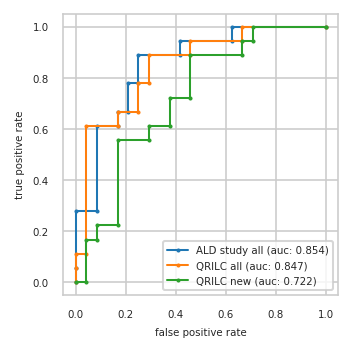

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.042 0.000
2          0.000 0.278     0.000 0.111     0.042 0.167
3          0.083 0.278     0.042 0.111     0.083 0.167
4          0.083 0.611     0.042 0.611     0.083 0.222
5          0.167 0.611     0.167 0.611     0.167 0.222
6          0.167 0.667     0.167 0.667     0.167 0.556
7          0.208 0.667     0.250 0.667     0.292 0.556
8          0.208 0.778     0.250 0.778     0.292 0.611
9          0.250 0.778     0.292 0.778     0.375 0.611
10         0.250 0.889     0.292 0.889     0.375 0.722
11         0.417 0.889     0.458 0.889     0.458 0.722
12         0.417 0.944     0.458 0.944     0.458 0.889
13         0.625 0.944     0.667 0.944     0.667 0.889
14         0.625 1.000     0.667 1.000     0.667 0.944
15         1.000 1.000     1.000 1.000     0.708 0.944
16           NaN   NaN       NaN   NaN     0.708 1.000
17           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P04075,Q9Y2T3;Q9Y2T3-3,P31321
1,Q9NRN5,P60709;P63261,None
2,P09486,A0A0C4DH07;Q8N2S1;Q8N2S1-2;Q8N2S1-3,None
3,K7ERG9;P00746,P10636-2;P10636-6,None
4,P14174,P61981,None
5,P10636-2;P10636-6,A0A0A0MRJ7;P12259,None
6,P61981,P14174,None
7,Q9Y2T3;Q9Y2T3-3,P04075,None
8,P18428,P05413;S4R371,None


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


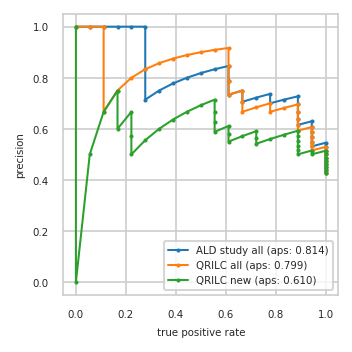

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.515 0.944     0.515 0.944
10         0.531 0.944     0.531 0.944     0.500 0.889
11         0.548 0.944     0.548 0.944     0.516 0.889
12         0.567 0.944     0.567 0.944     0.533 0.889
13         0.586 0.944     0.586 0.944     0.552 0.889
14         0.607 0.944     0.607 0.944     0.571 0.889
15         0.630 0.944     0.593 0.889     0.593 0.889
16         0.615 0.889     0.615 0.889     0.577 0.833
17         0.640 0.889     0.640 0.889     0.560 0.778
18         0.667 0.889     0.667 0.889     0.542 0.722
19         0.696 0.889     0.696 0.889     0.565 0.722
20         0.727 0.889     0.682 0.833     0.591 0.722
21         0.714 0.833     0.667 0.778     0.571 0.667
22         0.700 0.778     0.700 0.778     0.550 0.611
23         0.737 0.778     0.684 0.722     0.579 0.611
24         0.722 0.722     0.667 0.667     0.611 0.611
25         0.706 0.667     0.706 0.667     0.588 0.556
26         0.750 0.667     0.750 0.667     0.625 0.556
27         0.733 0.611     0.733 0.611     0.667 0.556
28         0.786 0.611     0.786 0.611     0.714 0.556
29         0.846 0.611     0.846 0.611     0.692 0.500
30         0.833 0.556     0.917 0.611     0.667 0.444
31         0.818 0.500     0.909 0.556     0.636 0.389
32         0.800 0.444     0.900 0.500     0.600 0.333
33         0.778 0.389     0.889 0.444     0.556 0.278
34         0.750 0.333     0.875 0.389     0.500 0.222
35         0.714 0.278     0.857 0.333     0.571 0.222
36         0.833 0.278     0.833 0.278     0.667 0.222
37         1.000 0.278     0.800 0.222     0.600 0.167
38         1.000 0.222     0.750 0.167     0.750 0.167
39         1.000 0.167     0.667 0.111     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


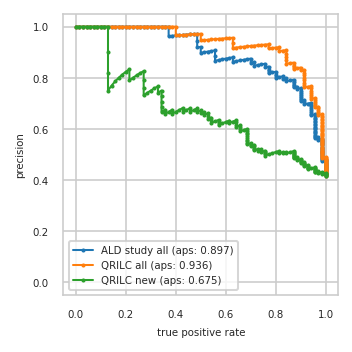

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


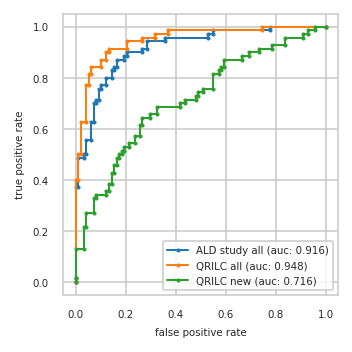

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}